# Test models

### Libraries

In [20]:
from pathlib import Path
from feature_extraction.bovw import BoVW
from feature_extraction.hog import get_hog_features
from utils.data_read_write import read_dataset
from utils.evaluation import probas_to_labels, merge_probas
from utils.preprocessing import label_to_category
import cv2
import pickle
import numpy as np
from sklearn.metrics import classification_report, plot_confusion_matrix
import scikitplot as skplt

### Parameters

In [21]:
TEST_DIR = Path("Dataset/GTSRB/Final_Test/Images")
TEST_LABELS_FILE = "Dataset/GT-final_test.csv"

IMG_SIZE = (32,32)
IMG_TYPE = "ppm"

RANDOM_STATE = 1234

VOCABULARY_SIZE = 600
SIFT_KWARGS = {
    "contrastThreshold":0.005,
    "sigma": 1.05,
    "edgeThreshold": 50
}

HOG_KWARGS = {
    'orientations':8, 
    'pixels_per_cell':(8, 8),
    'cells_per_block':(2, 2), 
    'feature_vector': True,
    'multichannel':True,
    'block_norm':'L2'
}

CLUSTER_MODEL_SAVE_FILE = 'models/BoVW/kmeans_32_600.sav'
SCALER_SAVE_FILE = 'models/BoVW/scaler.sav'

SVM_BOVW_CLASSES_SAVE_FILE = 'models/svm_bowv_classes.sav'
SVM_BOVW_CATEG_SAVE_FILE = 'models/svm_bowv_categories.sav'

SVM_HOG_CLASSES_SAVE_FILE = 'models/svm_hog_classes.sav'
SVM_HOG_CATEG_SAVE_FILE = 'models/svm_hog_categories.sav'

# Read test data

In [22]:
test_X, test_y = read_dataset(images_dir=TEST_DIR,
                              labels_file=TEST_LABELS_FILE,
                              delimiter=";",
                              file_type=IMG_TYPE,
                              img_shape=IMG_SIZE)

In [23]:
test_categories = np.int64(test_y)
test_categories = label_to_category(test_categories)
test_categories = np.float32(test_categories)
test_y = np.float32(test_y)

---
# Test BoVW

### Load bovw

In [24]:
bovw = BoVW(extractor = cv2.xfeatures2d.SIFT_create(**SIFT_KWARGS),
            train_images=None, 
            vocabulary_size=VOCABULARY_SIZE,
            cluster_model=CLUSTER_MODEL_SAVE_FILE,
            scaler=SCALER_SAVE_FILE)

Loading cluster model from file..
Loading scaler from file..


### Get test features

In [25]:
test_bovw_features = bovw.get_features(test_X)

  1%|▏         | 171/12630 [00:00<00:07, 1702.67it/s]

Extracting descriptors ...


  0%|          | 12/12630 [00:00<01:56, 108.74it/s]

Computing histograms ...


100%|██████████| 12630/12630 [01:57<00:00, 107.54it/s]


Normalizing histograms ...
Done


In [26]:
test_bovw_features = np.float32(test_bovw_features).reshape(len(test_bovw_features),-1)

## Case 1: Classes are independent

### Load model 

In [27]:
svm_bovw_classes = pickle.load(open(SVM_BOVW_CLASSES_SAVE_FILE, 'rb'))

### Predict and plot classification report

In [28]:
bovw_class_probas = svm_bovw_classes.predict_proba(test_bovw_features)
bovw_class_pred = probas_to_labels(bovw_class_probas)
bovw_class_pred = np.float32(bovw_class_pred)
print(classification_report(test_y, bovw_class_pred))

              precision    recall  f1-score   support

         0.0       0.45      0.72      0.55        60
         1.0       0.90      0.57      0.70       720
         2.0       0.82      0.65      0.73       750
         3.0       0.67      0.70      0.68       450
         4.0       0.66      0.71      0.68       660
         5.0       0.61      0.59      0.60       630
         6.0       0.85      0.89      0.87       150
         7.0       0.63      0.74      0.68       450
         8.0       0.69      0.72      0.70       450
         9.0       0.86      0.86      0.86       480
        10.0       0.84      0.71      0.77       660
        11.0       0.85      0.69      0.76       420
        12.0       0.79      0.79      0.79       690
        13.0       0.84      0.72      0.78       720
        14.0       0.93      0.82      0.87       270
        15.0       0.73      0.91      0.81       210
        16.0       0.80      0.91      0.85       150
        17.0       0.78    

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

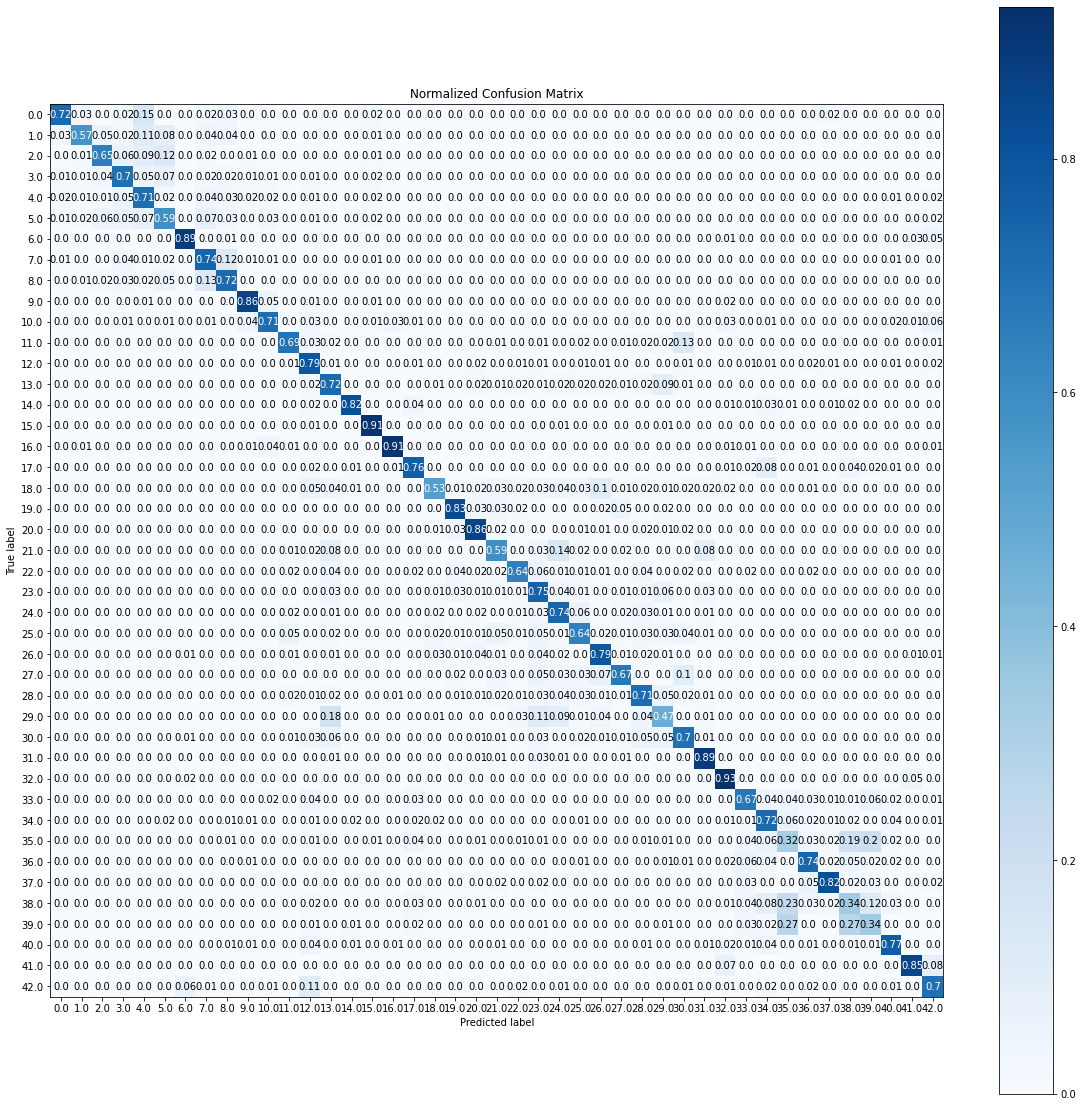

In [29]:
skplt.metrics.plot_confusion_matrix(test_y, bovw_class_pred, figsize=(20,20), normalize=True)

## Case 2: Classes are grouped to categories

### Load model

In [30]:
svm_bovw_categories = pickle.load(open(SVM_BOVW_CATEG_SAVE_FILE, 'rb'))

### Predict and plot classification report

In [31]:
bovw_categ_probas = svm_bovw_categories.predict_proba(test_bovw_features)
bovw_categ_pred = probas_to_labels(bovw_categ_probas)
bovw_categ_pred = np.float32(bovw_categ_pred)
print(classification_report(test_categories, bovw_categ_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      4170
         1.0       0.83      0.86      0.85      1500
         2.0       0.62      0.93      0.75       360
         3.0       0.85      0.89      0.87      1770
         4.0       0.87      0.95      0.91      2790
         5.0       0.87      0.74      0.80      2040

    accuracy                           0.89     12630
   macro avg       0.84      0.88      0.85     12630
weighted avg       0.89      0.89      0.89     12630



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

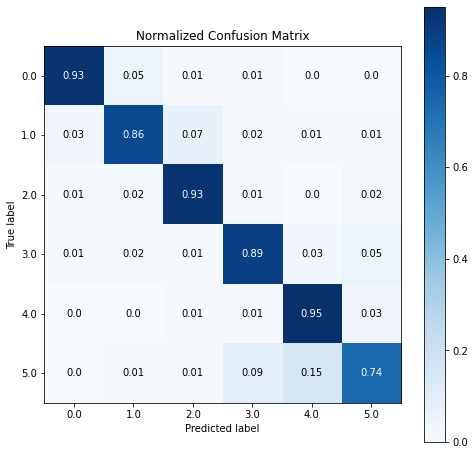

In [32]:
skplt.metrics.plot_confusion_matrix(test_categories, bovw_categ_pred, figsize=(8,8), normalize=True)

# Test HOG

### Get test features

In [33]:
test_hog_features = get_hog_features(test_X, **HOG_KWARGS)

100%|██████████| 12630/12630 [00:05<00:00, 2308.93it/s]


## Case 1: Classes are independent

### Load SVM

In [34]:
svm_hog_classes = pickle.load(open(SVM_HOG_CLASSES_SAVE_FILE, 'rb'))

### Predict and plot classification report

In [35]:
hog_class_probas = svm_hog_classes.predict_proba(test_hog_features)
hog_class_pred = probas_to_labels(hog_class_probas)
hog_class_pred = np.float32(hog_class_pred)
print(classification_report(test_y, hog_class_pred))

              precision    recall  f1-score   support

         0.0       0.34      0.42      0.37        60
         1.0       0.80      0.32      0.45       720
         2.0       0.72      0.42      0.53       750
         3.0       0.54      0.62      0.58       450
         4.0       0.73      0.75      0.74       660
         5.0       0.43      0.46      0.44       630
         6.0       0.83      0.79      0.81       150
         7.0       0.61      0.33      0.43       450
         8.0       0.30      0.55      0.39       450
         9.0       0.82      0.76      0.79       480
        10.0       0.92      0.57      0.70       660
        11.0       0.64      0.35      0.45       420
        12.0       0.85      0.99      0.91       690
        13.0       0.98      0.99      0.99       720
        14.0       0.97      0.79      0.87       270
        15.0       0.30      0.96      0.46       210
        16.0       0.49      0.96      0.65       150
        17.0       0.95    

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

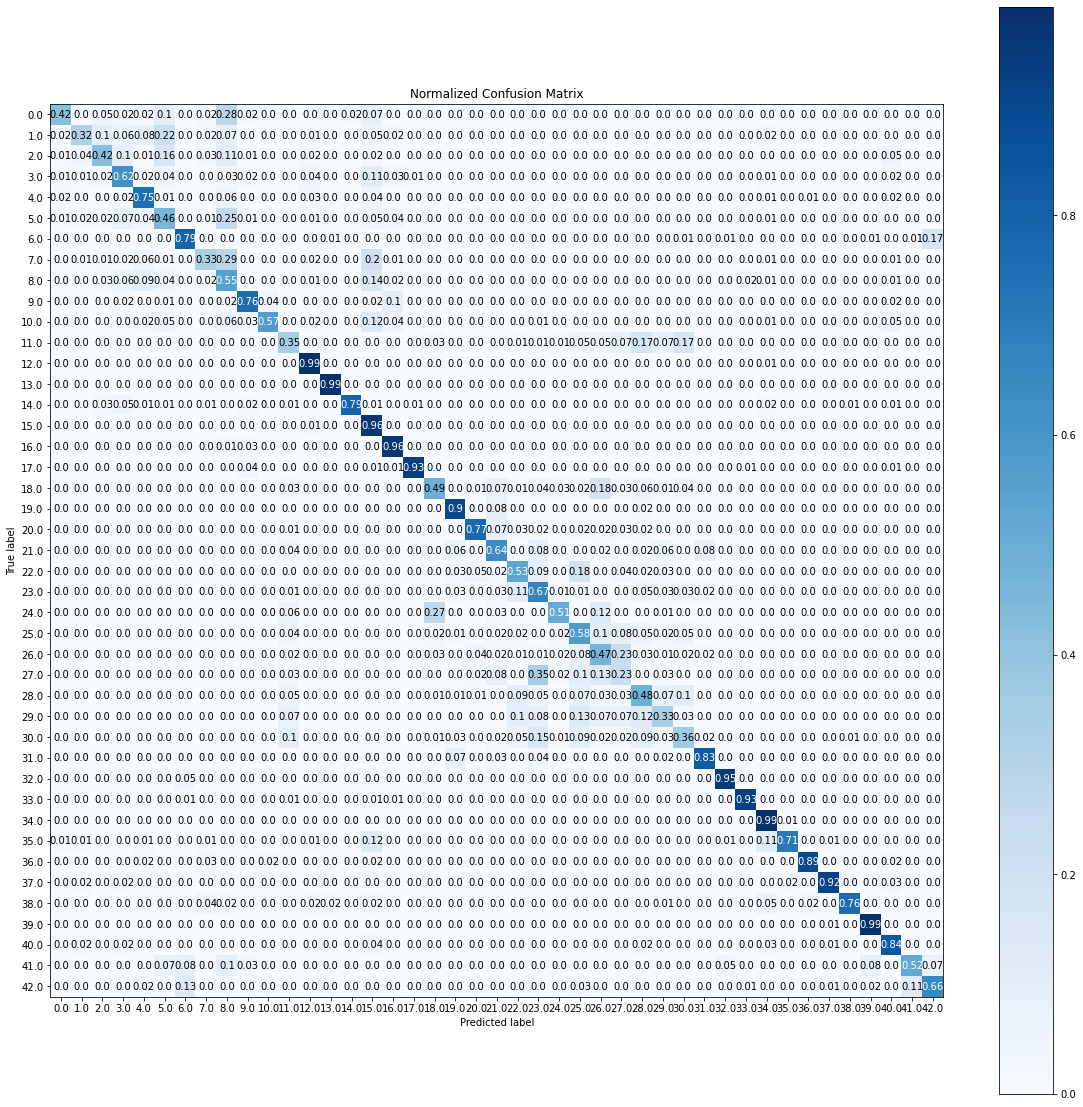

In [36]:
skplt.metrics.plot_confusion_matrix(test_y, hog_class_pred, figsize=(20,20), normalize=True)

## Case 2: Classes are grouped to categories

### Load model

In [37]:
svm_hog_categories = pickle.load(open(SVM_HOG_CATEG_SAVE_FILE, 'rb'))

### Predict and plot classification report

In [38]:
hog_categ_probas = svm_hog_categories.predict_proba(test_hog_features)
hog_categ_pred = probas_to_labels(hog_categ_probas)
hog_categ_pred = np.float32(hog_categ_pred)
print(classification_report(test_categories, hog_categ_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90      4170
         1.0       0.79      0.92      0.85      1500
         2.0       0.95      0.96      0.95       360
         3.0       0.83      0.92      0.88      1770
         4.0       0.98      1.00      0.99      2790
         5.0       0.93      0.97      0.95      2040

    accuracy                           0.92     12630
   macro avg       0.91      0.93      0.92     12630
weighted avg       0.93      0.92      0.92     12630



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

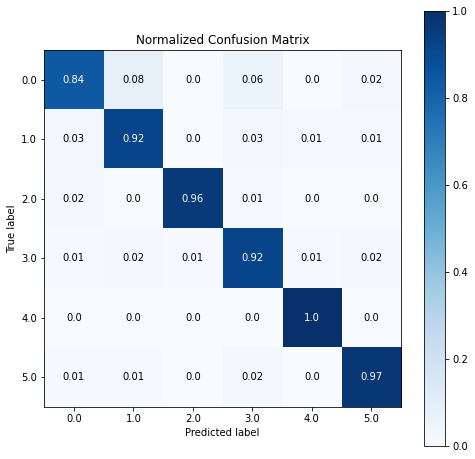

In [39]:
skplt.metrics.plot_confusion_matrix(test_categories, hog_categ_pred, figsize=(8,8), normalize=True)

# Testing HOG+BoVW (merged)

## Separate classes

In [41]:
hog_bovw_class_probas = merge_probas(hog_class_probas, bovw_class_probas)
hog_bovw_class_pred = probas_to_labels(hog_bovw_class_probas)
hog_bovw_class_pred = np.float32(hog_bovw_class_pred)
print(classification_report(test_y, hog_bovw_class_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.73      0.66        60
         1.0       0.96      0.55      0.69       720
         2.0       0.89      0.63      0.74       750
         3.0       0.72      0.75      0.74       450
         4.0       0.76      0.83      0.80       660
         5.0       0.64      0.63      0.63       630
         6.0       0.89      0.90      0.90       150
         7.0       0.74      0.60      0.66       450
         8.0       0.58      0.80      0.67       450
         9.0       0.89      0.91      0.90       480
        10.0       0.93      0.74      0.83       660
        11.0       0.86      0.64      0.73       420
        12.0       0.87      0.98      0.92       690
        13.0       0.96      0.99      0.98       720
        14.0       0.99      0.86      0.92       270
        15.0       0.41      0.99      0.58       210
        16.0       0.71      0.99      0.83       150
        17.0       0.91    

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

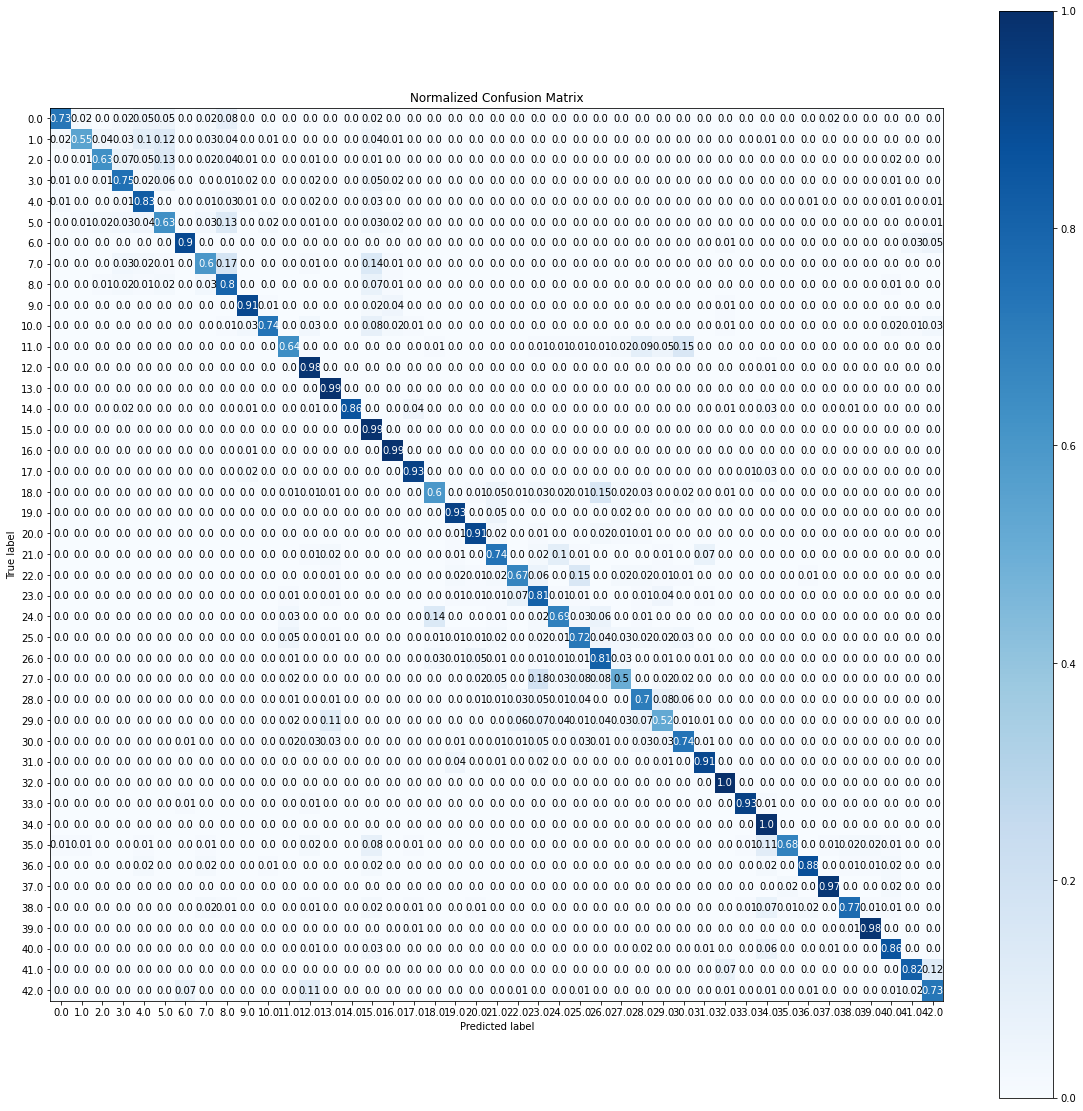

In [44]:
skplt.metrics.plot_confusion_matrix(test_y, hog_bovw_class_pred, figsize=(20,20), normalize=True)

In [43]:
hog_bovw_categ_probas = merge_probas(hog_categ_probas, bovw_categ_probas)
hog_bovw_categ_pred = probas_to_labels(hog_bovw_categ_probas)
hog_bovw_categ_pred = np.float32(hog_bovw_categ_pred)
print(classification_report(test_categories, hog_bovw_categ_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96      4170
         1.0       0.89      0.95      0.92      1500
         2.0       0.92      0.97      0.95       360
         3.0       0.93      0.96      0.94      1770
         4.0       0.98      1.00      0.99      2790
         5.0       0.96      0.96      0.96      2040

    accuracy                           0.96     12630
   macro avg       0.95      0.96      0.95     12630
weighted avg       0.96      0.96      0.96     12630



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

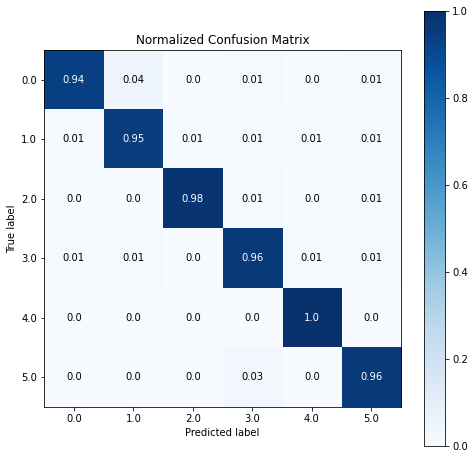

In [45]:
skplt.metrics.plot_confusion_matrix(test_categories, hog_bovw_categ_pred, figsize=(8,8), normalize=True)